In [1]:
# pip install requests_toolbelt

In [2]:
from flask import Flask, render_template, request, url_for
import pickle
from tensorflow.keras.models import load_model
import noisereduce as nr
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os
import io
import pandas as pd
import numpy as np
import soundfile
from werkzeug.utils import secure_filename
from pydub.utils import make_chunks

# from requests_toolbelt.multipart import decoder


In [3]:
host_addr = "0.0.0.0"
port_num = "5050"
sr = 16000

In [4]:
def add_whitenoise(sig):
  wn = np.random.randn(len(sig))
  wn_1000=wn/1000*np.random.randint(1,6)
  sig_wn = sig + wn_1000
  return sig_wn

def shift_audio(sig, shift):
  sig_roll = np.roll(sig, shift)
  return sig_roll

def stratch_audio(sig, rate):
  input_length = len(sig)
  sig = librosa.effects.time_stretch(sig, rate)
  if len(sig)>input_length:
      sig = sig[:input_length]
  else:
      sig = np.pad(sig, (0, max(0, input_length - len(sig))), "constant")
  return sig

In [5]:
def file_transform(sig):
    global sr
    sig_lst = []
    
    rate=np.random.randint(3, 25) / 10
    shift=np.random.randint(-9, 9)*sr
    
    sig=nr.reduce_noise(y=sig, sr=sr)

    sig_wn=add_whitenoise(sig)

    sig_strech1 = stratch_audio(sig_wn, rate=rate)

    sig_roll = shift_audio(sig_strech1, shift=shift)

    return sig_roll

In [6]:
def gen_mfcc(sig):
      
  # 상수 정의
  sample_rate=16000
  length = len(sig)/sample_rate   # 음악의 길이는 음파 길이(len(sig)) / sr
  n_fft=int(sample_rate*0.025)
  hop_length=int(sample_rate*0.01)
  r=length/9  # 분모를 조절하면 몇초동안 재생되는지 조절 가능

  # 진폭 정규화
  sig=(sig + sig.mean()) * 1/max(np.abs(sig))   

  # stft 분석을 하는 코드
  stft = librosa.stft(sig, n_fft=n_fft, hop_length=hop_length) 

  # 음원 데이터의 길이 정규화
  p_stft=librosa.phase_vocoder(stft, rate=r, hop_length=hop_length)

  mel_spec=librosa.feature.melspectrogram(S=p_stft, sr=sample_rate, n_mels=128, hop_length=hop_length)

  log_M=librosa.amplitude_to_db(mel_spec)

  # mfcc를 이용한 feature값 계산. n_mfcc는 추출하고자 하는 mfcc의 갯수
  mfcc = librosa.feature.mfcc(S=log_M, n_mfcc=30, sr=sample_rate)

  return mfcc

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000 (Press CTRL+C to quit)
127.0.0.1 - - [15/Jun/2022 17:19:53] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [15/Jun/2022 17:19:53] "GET /static/img/mask2.png HTTP/1.1" 304 -
127.0.0.1 - - [15/Jun/2022 17:19:55] "GET /selectNum HTTP/1.1" 200 -
127.0.0.1 - - [15/Jun/2022 17:19:55] "GET /static/img/coronavirus1.png HTTP/1.1" 304 -
127.0.0.1 - - [15/Jun/2022 17:19:55] "GET /static/img/coronavirus2.png HTTP/1.1" 304 -
127.0.0.1 - - [15/Jun/2022 17:19:55] "GET /static/img/coronavirus3.png HTTP/1.1" 304 -
127.0.0.1 - - [15/Jun/2022 17:19:57] "POST /spinning2 HTTP/1.1" 200 -
127.0.0.1 - - [15/Jun/2022 17:19:58] "POST /result HTTP/1.1" 200 -
127.0.0.1 - - [15/Jun/2022 17:19:58] "GET /static/img/wav/test_singnal243.png HTTP/1.1" 304 -
127.0.0.1 - - [15/Jun/2022 17:19:58] "GET /static/img/mfcc/test_mfcc243.png HTTP/1.1" 200 -
127.0.0.1 - - [15/Jun/2022 17:19:59] "GET /static/audio/test_blob243.wav HTTP/1.1" 206 -
127.0.0.1 - - [15/Jun/2022 17:19:59] "GET /static/audio/aug

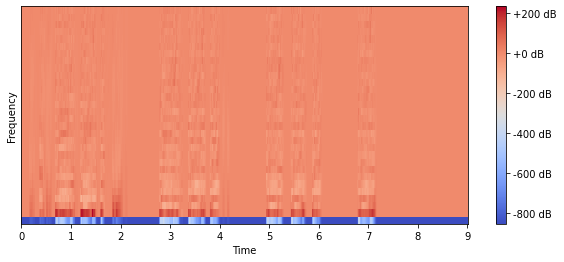

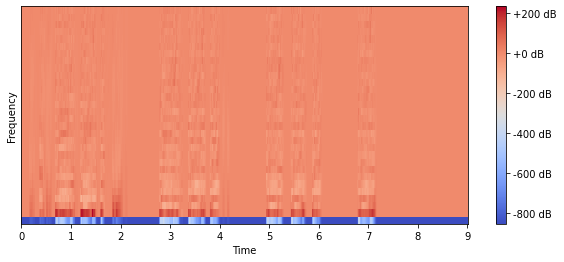

In [19]:
app = Flask(__name__)

filename = ""

# 웹 페이지 접속시 메인 화면
@app.route('/',  methods=['GET'])
def main_loading():
    mask = "img/mask2.png"
    return render_template("main.html", mask = mask)

@app.route('/selectNum',  methods=['GET'])
def select_number():
    covid1 = "img/coronavirus1.png"
    covid2 = "img/coronavirus2.png"
    covid3 = "img/coronavirus3.png"

    return render_template("select_number.html", coivd1=covid1, coivd2=covid2, coivd3=covid3 )

@app.route('/set',  methods=['POST'])
def set():
    global filename 
    if 'audio_blob' in request.files:
        file = request.files['audio_blob']
        # Write the data to a file.
        
        filename = secure_filename(file.filename)
        cnt = 0
        if filename+".wav" in os.listdir('./static/audio/'):
            while filename +str(cnt) + ".wav" in os.listdir('./static/audio/'):
                cnt += 1
            filename = filename +str(cnt)
        filepath = "./static/audio/" + filename
        file.save(filepath + ".wav")

    return str(cnt)

@app.route('/spinning1',  methods=['POST'])
def spinning1():
    age = request.form["age"]
    gender = request.form["gender"]
    healthy = request.form.getlist("healty")
    cnt = request.form["cnt"]
    return render_template("spinning1.html", age=age, gender=gender, healthy=healthy, cnt=cnt)

@app.route('/spinning2',  methods=['POST'])
def spinning2():
    test_number = request.form["test_number"]
    return render_template("spinning2.html", test_number = test_number)
    
# 파일 업로드 및 해당 파일 화면에 출력
@app.route('/result',  methods=['POST'])
def upload_file():
    ##### 테스트 데이터
    if 'test_number' in request.form.keys():
        # 웹에서 가져온 인덱스 설정
        test_number = request.form["test_number"]
        index_in= int(test_number)-1   # input으로 받은 index가 여기 들어감

        # pickle로 테스트 데이터 압축해제 및 로드
        with open('./data/new_test_df_merge_mfcc.pickle', 'rb') as f:
            data = pickle.load(f)

        length=[]
        for i in range(len(data)):
            length.append(data[i].shape[1])
            
        min_len=min(length)

        result=[]
        for i in range(len(data)):
            result.append(data[i][:,:min_len])
            
        result_data=np.array(result)

        # 선택한 오디오 파일이 test 오디오 폴더에 없을 경우에만 오디오 변환
        if "test_blob"+test_number+".wav" not in os.listdir("./static/audio/"):
            # mfcc로 된 데이터 signal로 역변환
            inverse_mel=librosa.feature.inverse.mfcc_to_mel(result_data[index_in], n_mels=128)
            inverse_audio=librosa.feature.inverse.mel_to_audio(inverse_mel, sr=16000, n_fft=int(16000*0.025), hop_length=int(16000*0.01) )

            # wav 이미지 저장
            plt.figure(figsize=(10,4))
            librosa.display.waveshow(inverse_audio, alpha = 0.5)
            plt.savefig('./static/img/wav/test_singnal'+test_number+'.png')

            # 오디오 원본 저장
            soundfile.write("./static/audio/test_blob"+test_number+".wav", inverse_audio, 16000)

            # augmentation 생성 및 저장
            for i in range(3):
                aug = file_transform(inverse_audio)
                soundfile.write("./static/audio/aug/test_blob_"+test_number+"_aug_"+str(i +1)+".wav", aug, 16000)

        # csv 파일 로드
        df=pd.read_csv("./data/new_test_df_merge.csv")
        feature=df.iloc[:, [4,5,6]].values
        real_y=df.iloc[:, 7].values

        # 분석 진행
        result_data[index_in].reshape(1,30,901)
        feature[index_in].reshape(1,3)
        if index_in < 520:
            model=load_model('./model/1565_model.h5')
            y_train_pred=model.predict([result_data[index_in].reshape(1,30,901), feature[index_in].reshape(1,3)])
            if y_train_pred>=0.5:
                yhat=1
            else:
                yhat=0
        else:
            model=load_model('./model/other_model.h5')
            y_train_pred=model.predict([result_data[index_in].reshape(1,30,901), feature[index_in].reshape(1,3)])
            if y_train_pred>=0.5:
                yhat=1
            else:
                yhat=0
        # mfcc 이미지 저장
        fig = plt.figure(figsize = (10,4))
        librosa.display.specshow(result_data[index_in], 
                                sr=16000, 
                                hop_length=int(16000*0.01),
                                x_axis='time',)
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.colorbar(format='%+2.0f dB')
        plt.savefig('./static/img/mfcc/test_mfcc'+test_number+'.png')

        

            
        # 리턴
        if index_in < 520:
            age = "15세이상 65세 미만"
        else:
            age = "15세미만 65세 이상"
        age = "15세이상 65세 미만"
        gender = "여성" if df.iloc[index_in,[4]].values[0]==0 else "남성"
        yhat = "양성" if yhat == 1 else "음성"
        real_y = "양성" if real_y[index_in] == 1 else "음성"
        healthy1 = "없음" if df.iloc[index_in,5] == 0 else "있음"
        healthy2 = "없음" if df.iloc[index_in,6] == 0 else "있음"
        aug1 = "audio/aug/test_blob_"+test_number+"_aug_1.wav"
        aug2 = "audio/aug/test_blob_"+test_number+"_aug_2.wav"
        aug3 = "audio/aug/test_blob_"+test_number+"_aug_3.wav"
        wav_img = 'img/wav/test_singnal'+test_number+'.png'
        mfcc_img = 'img/mfcc/test_mfcc'+test_number+'.png'
        return render_template("result.html", index = index_in+1,age=age, gender=gender, healthy1=healthy1, healthy2=healthy2,
                                pred=y_train_pred[0][0], yhat= yhat, real_y=real_y, audio_1=aug1, audio_2=aug2, audio_3=aug3,
                                    audio_or="audio/test_blob"+test_number+".wav", wav_img=wav_img, mfcc_img=mfcc_img)
        ##### 직접 녹음한 기침 데이터


    elif 'age' in request.form.keys():
        filename = "blob"
        # 파일 정보 받아오기
        age = request.form["age"]
        gender = request.form["gender"]
        healthy = request.form.getlist("healty")
        cnt = request.form["cnt"]
        # 입력정보로 feature 생성
        age=int(age)

        if gender=='male':
            man=1
        else:
            man=0

        if 'respiratory_condition' in healthy:
            res=1
        else:
            res=0

        if 'fever_muscle_pain' in healthy:
            fever=1
        else: 
            fever=0
    
        feature=np.array([man, res, fever])

        # 음원 로드하여 테스트 데이터 생성
        sig, sr = librosa.load('./static/audio/' + "blob" +cnt+ ".wav", sr = 16000)
        sig=nr.reduce_noise(y=sig, sr=sr, stationary=False)
        mfcc=gen_mfcc(sig)
        test_mfcc=mfcc[:, :901]

        # sig 이미지 생성
        plt.figure(figsize=(12,8))
        librosa.display.waveshow(sig, alpha = 0.5)
        plt.savefig('./static/img/wav/signal'+cnt+'.png')

        # mfcc 이미지 생성
        fig = plt.figure(figsize = (12,8))
        librosa.display.specshow(test_mfcc, 
                                sr=sr, 
                                hop_length=int(16000*0.01),
                                x_axis='time',)
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.colorbar(format='%+2.0f dB')
        plt.savefig('./static/img/mfcc/mfcc'+cnt+'.png')

        # augmentation file 생성
        for i in range(3):
            aug = file_transform(sig)
            soundfile.write("./static/audio/aug/" + "blob" + cnt +"_aug_" + str(i + 1) + ".wav", aug, 16000)

        if age>=15 and age<=65 :
            model=load_model('./model/1565_model.h5')
            y_train_pred=model.predict([test_mfcc.reshape(1,30,901), feature.reshape(1,3)])
            if y_train_pred>=0.5:
                yhat=1
            else:
                yhat=0

        else :
            model=load_model('./model/other_model.h5')
            y_train_pred=model.predict([test_mfcc.reshape(1,30,901), feature.reshape(1,3)])
            if y_train_pred>=0.5:
                yhat=1
            else:
                yhat=0
        yhat = "양성" if yhat == 1 else "음성"
        aug1 = "audio/aug/" + "blob" + cnt + "_aug_1"  + ".wav"
        aug2 = "audio/aug/" + "blob" + cnt + "_aug_2"  + ".wav"
        aug3 = "audio/aug/" + "blob" + cnt + "_aug_3"  + ".wav"
        wav_img = "img/wav/signal"+cnt+".png"
        mfcc_img = "img/mfcc/mfcc"+cnt+".png"
        healthy1 = "있음" if "respiratory_condition" in healthy else "없음"
        healthy2 = "있음" if "fever_muscle_pain" in healthy else "없음"
        return render_template("result.html", age=age, gender=gender, healthy1=healthy1, healthy2=healthy2,
                                pred=y_train_pred[0][0], yhat=yhat, audio_1=aug1, audio_2=aug2, audio_3=aug3,
                                    audio_or="audio/" + "blob" + cnt + ".wav", wav_img=wav_img, mfcc_img=mfcc_img)




if __name__ == "__main__":
    app.run()  